# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras.models import Sequential,Model
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.layers import Dense,Embedding,Flatten,Input,Concatenate, Reshape, Dropout,merge,Activation,LSTM,GRU,SimpleRNN,Conv1D, MaxPooling1D, Flatten
from tensorflow.python.keras.layers import merge
import pandas as pd
import numpy as np

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#! pip install categorical_embedder
#import categorical_embedder as ce

# Data Preprocessing

In [2]:
df = pd.read_csv('data_prep_bin_traffic.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,Day_Week,Weekend,weather_desc,weather_bin,snow_bin,holi
0,NaN,15.13,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,5545.0,1,0,1,1,0,0
1,NaN,16.21,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 10:00:00,4516.0,1,0,1,1,0,0
2,NaN,16.43,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 11:00:00,4767.0,1,0,1,1,0,0
3,NaN,16.98,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 12:00:00,5026.0,1,0,1,1,0,0
4,NaN,17.99,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 13:00:00,4918.0,1,0,1,1,0,0


In [3]:
# Convert 'date_time' column to datetime format if it's not already
df['date_time'] = pd.to_datetime(df['date_time'])

# Now you can use the .dt accessor to extract year, month, weekday, and hour
new_df = df.copy()
new_df['year'] = new_df['date_time'].dt.year
new_df['month'] = new_df['date_time'].dt.month
new_df['weekday'] = new_df['date_time'].dt.weekday
new_df['hour'] = new_df['date_time'].dt.hour

new_df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,Day_Week,Weekend,weather_desc,weather_bin,snow_bin,holi,year,month,weekday,hour
0,NaN,15.13,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,5545.0,1,0,1,1,0,0,2012,10,1,9
1,NaN,16.21,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 10:00:00,4516.0,1,0,1,1,0,0,2012,10,1,10
2,NaN,16.43,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 11:00:00,4767.0,1,0,1,1,0,0,2012,10,1,11
3,NaN,16.98,0.0,0.0,90.0,Clouds,overcast clouds,2012-10-02 12:00:00,5026.0,1,0,1,1,0,0,2012,10,1,12
4,NaN,17.99,0.0,0.0,75.0,Clouds,broken clouds,2012-10-02 13:00:00,4918.0,1,0,1,1,0,0,2012,10,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44699,NaN,10.30,0.0,0.0,75.0,Clouds,broken clouds,2018-09-30 19:00:00,3543.0,6,1,1,1,0,0,2018,9,6,19
44700,NaN,9.61,0.0,0.0,90.0,Clouds,overcast clouds,2018-09-30 20:00:00,2781.0,6,1,1,1,0,0,2018,9,6,20
44701,NaN,9.58,0.0,0.0,90.0,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159.0,6,1,8,0,0,0,2018,9,6,21
44702,NaN,8.94,0.0,0.0,90.0,Clouds,overcast clouds,2018-09-30 22:00:00,1450.0,6,1,1,1,0,0,2018,9,6,22


In [4]:
# Creating a new column for categorizing hours into parts of a day.

def categorize_hour(hour):
    cat = None
    if hour in [1,2,3,4,5]:
        cat = 'dawn'
    elif hour in [6,7,8,9,10,11,12]:
        cat = 'morning'
    elif hour in [13,14,15,16,17,18]:
        cat = 'afternoon'
    elif hour in [19,20,21,22,23,0]:
        cat = 'night'

    return cat

In [10]:
new_df['day_part'] = new_df['hour'].map(categorize_hour)
new_df.set_index('date_time',inplace=True)
new_df.head()

#new_df.to_csv('final_dataset.csv', index=False)

# EDA b4 preprocessing

- Rolling mean for Date Time against Traffic_Volume

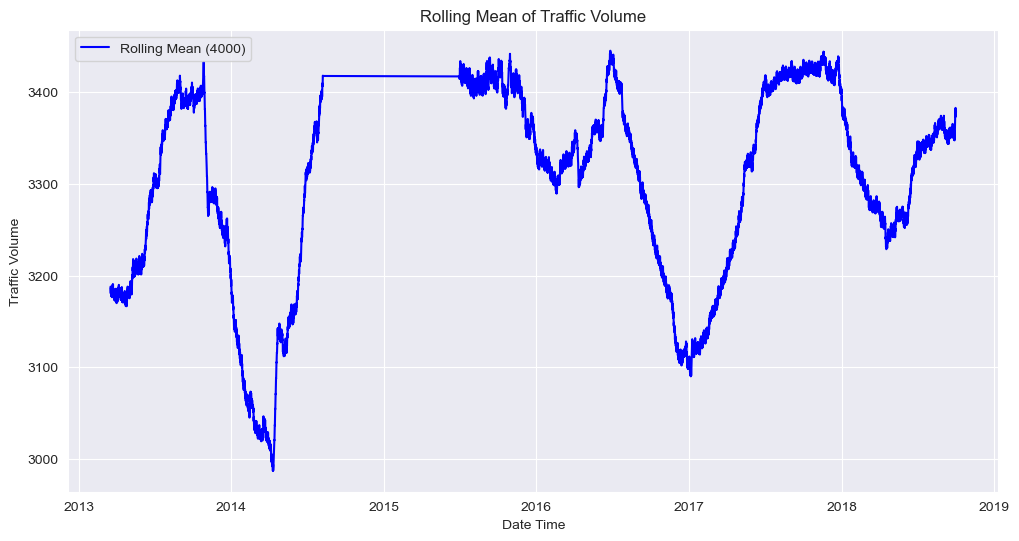

In [63]:
# Calculate the rolling mean
rolling_mean = new_df.sort_index()['traffic_volume'].rolling(4000).mean()

# Plot the rolling mean
plt.figure(figsize=(12, 6))
plt.plot(rolling_mean, color='blue', label='Rolling Mean (4000)')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Rolling Mean of Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()


- Holiday against Traffic_Volume

In [64]:
def scatter_compareplot(x_feature, y_feature, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=x_feature, y=y_feature, color='skyblue', marker='o', s=50)
    plt.xlabel(xlabel, fontsize=12, fontweight='bold')
    plt.ylabel(ylabel, fontsize=12, fontweight='bold')
    plt.title('Scatter Plot Comparison', fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.show()

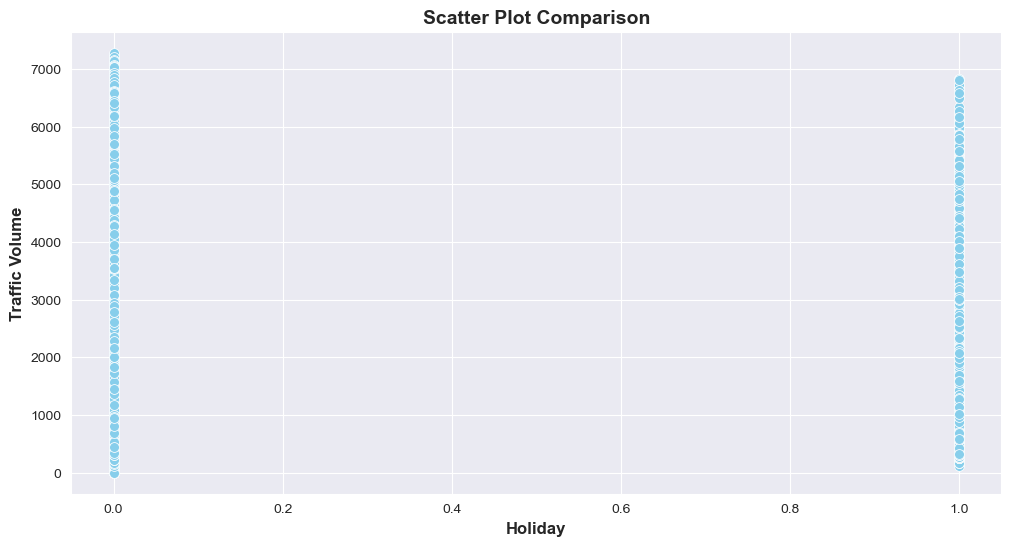

In [66]:
scatter_compareplot(new_df['holi'], new_df['traffic_volume'], 'Holiday', 'Traffic Volume')

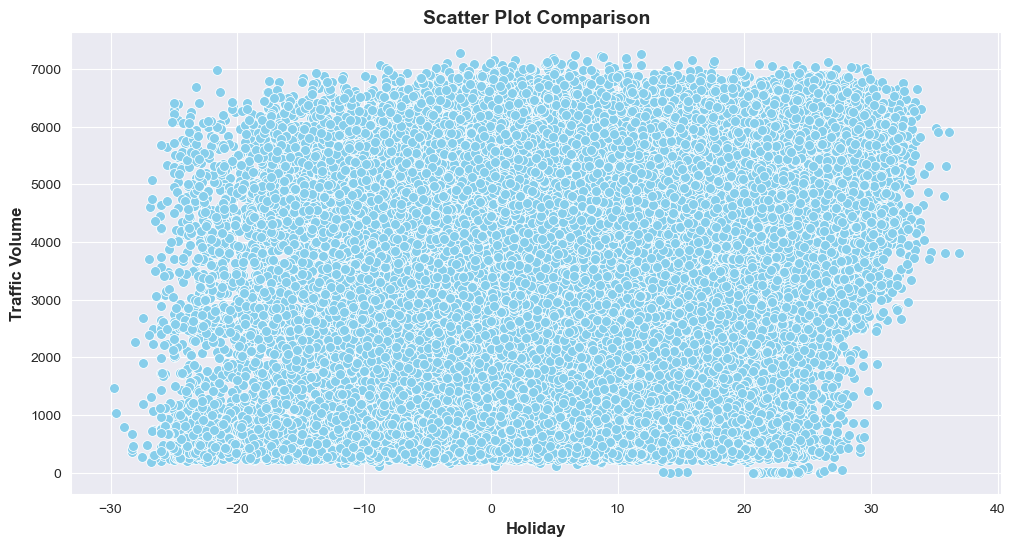

In [67]:
scatter_compareplot(new_df['temp'], new_df['traffic_volume'], 'Holiday', 'Traffic Volume')

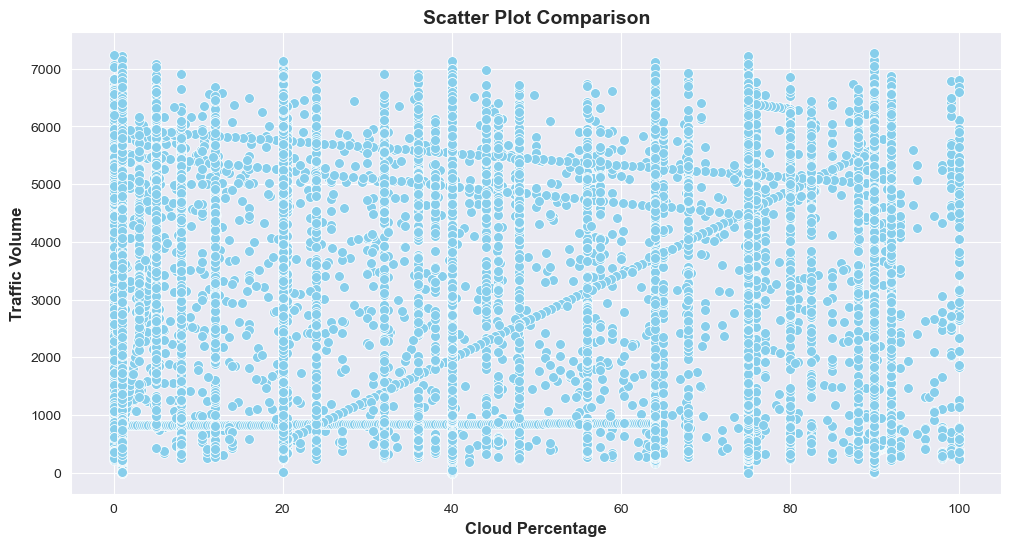

In [68]:
scatter_compareplot(new_df['clouds_all'], new_df['traffic_volume'], 'Cloud Percentage', 'Traffic Volume')

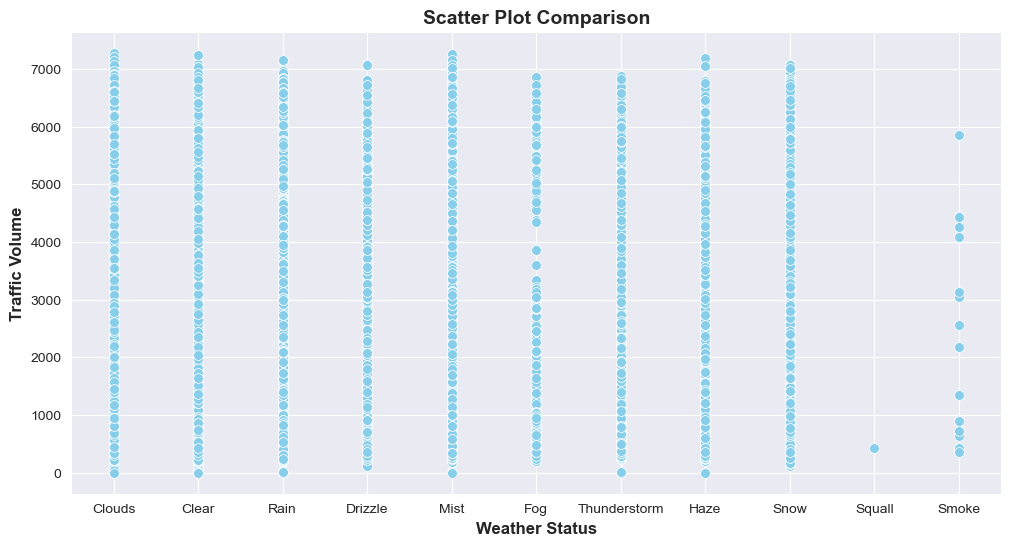

In [73]:
scatter_compareplot(new_df['weather_main'], new_df['traffic_volume'], 'Weather Status', 'Traffic Volume')


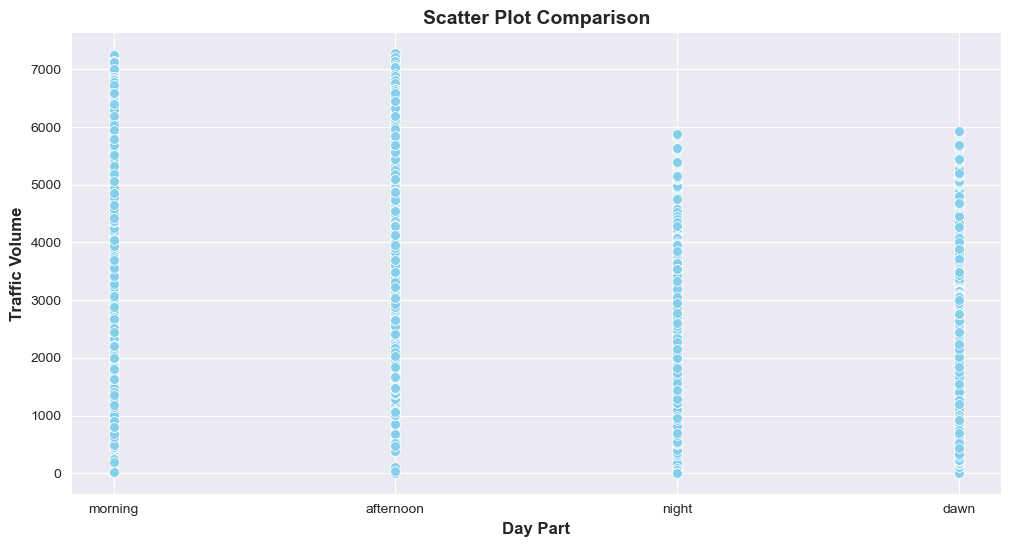

In [69]:
scatter_compareplot(new_df['day_part'], new_df['traffic_volume'], 'Day Part', 'Traffic Volume')

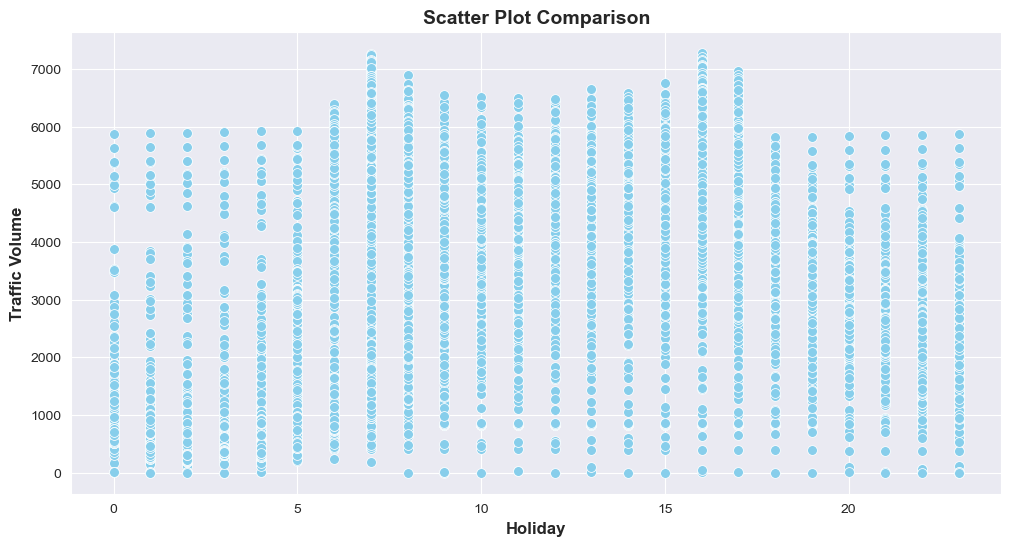

In [70]:
scatter_compareplot(new_df['hour'], new_df['traffic_volume'], 'Holiday', 'Traffic Volume')


# Feature Transformation

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

num_feats = new_df.copy()
for column in num_feats.columns:
    if num_feats[column].dtypes == 'object':
        num_feats[column] = le.fit_transform(num_feats[column])
        
num_feats

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,Day_Week,Weekend,weather_desc,weather_bin,snow_bin,holi,year,month,weekday,hour,day_part
date_time,,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,11,15.13,0.0,0.0,40.0,1,22,5545.0,1,0,1,1,0,0,2012,10,1,9,2
2012-10-02 10:00:00,11,16.21,0.0,0.0,75.0,1,0,4516.0,1,0,1,1,0,0,2012,10,1,10,2
2012-10-02 11:00:00,11,16.43,0.0,0.0,90.0,1,17,4767.0,1,0,1,1,0,0,2012,10,1,11,2
2012-10-02 12:00:00,11,16.98,0.0,0.0,90.0,1,17,5026.0,1,0,1,1,0,0,2012,10,1,12,2
2012-10-02 13:00:00,11,17.99,0.0,0.0,75.0,1,0,4918.0,1,0,1,1,0,0,2012,10,1,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,11,10.30,0.0,0.0,75.0,1,0,3543.0,6,1,1,1,0,0,2018,9,6,19,3
2018-09-30 20:00:00,11,9.61,0.0,0.0,90.0,1,17,2781.0,6,1,1,1,0,0,2018,9,6,20,3
2018-09-30 21:00:00,11,9.58,0.0,0.0,90.0,10,19,2159.0,6,1,8,0,0,0,2018,9,6,21,3


In [12]:
exp1 = num_feats.copy()
exp1 = exp1.drop(columns=['holiday','weather_main','weather_description'])
exp1.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day_Week,Weekend,weather_desc,weather_bin,snow_bin,holi,year,month,weekday,hour,day_part
date_time,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,15.13,0.0,0.0,40.0,5545.0,1,0,1,1,0,0,2012,10,1,9,2
2012-10-02 10:00:00,16.21,0.0,0.0,75.0,4516.0,1,0,1,1,0,0,2012,10,1,10,2
2012-10-02 11:00:00,16.43,0.0,0.0,90.0,4767.0,1,0,1,1,0,0,2012,10,1,11,2
2012-10-02 12:00:00,16.98,0.0,0.0,90.0,5026.0,1,0,1,1,0,0,2012,10,1,12,2
2012-10-02 13:00:00,17.99,0.0,0.0,75.0,4918.0,1,0,1,1,0,0,2012,10,1,13,0


In [13]:
# Create an instance of MinMaxScaler with a feature range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data using the MinMaxScaler
expe1 = scaler.fit_transform(exp1)

expe1 = pd.DataFrame(expe1, columns=exp1.columns, index=exp1.index)
expe1.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day_Week,Weekend,weather_desc,weather_bin,snow_bin,holi,year,month,weekday,hour,day_part
date_time,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,0.673215,0.0,0.0,0.40,0.761676,0.166667,0.0,0.125,1.0,0.0,0.0,0.0,0.818182,0.166667,0.391304,0.666667
2012-10-02 10:00:00,0.689412,0.0,0.0,0.75,0.620330,0.166667,0.0,0.125,1.0,0.0,0.0,0.0,0.818182,0.166667,0.434783,0.666667
2012-10-02 11:00:00,0.692711,0.0,0.0,0.90,0.654808,0.166667,0.0,0.125,1.0,0.0,0.0,0.0,0.818182,0.166667,0.478261,0.666667
2012-10-02 12:00:00,0.700960,0.0,0.0,0.90,0.690385,0.166667,0.0,0.125,1.0,0.0,0.0,0.0,0.818182,0.166667,0.521739,0.666667
2012-10-02 13:00:00,0.716107,0.0,0.0,0.75,0.675549,0.166667,0.0,0.125,1.0,0.0,0.0,0.0,0.818182,0.166667,0.565217,0.000000


# 1. Short-list promising models 

# 1.1 Model Training

In [17]:
X_1 = expe1[['temp', 'rain_1h', 'snow_bin', 'clouds_all', 'Day_Week', 'Weekend', 'weather_desc', 'holi', 'month', 'hour', 'day_part']]

#X_1 = df[['temp', 'rain_1h', 'snow_bin', 'clouds_all', 'Day_Week', 'Weekend', 'weather_desc', 'holi', 'weather_main' ]]


y_1 = expe1['traffic_volume']

# Define the indices for splitting the data
split_index = int(0.7 * len(X_1))  # 70% for training, 30% for testing
print(split_index)
# Split the features and target variables accordingly
X_train_1, X_test_1 = X_1[:split_index], X_1[split_index:]
y_train_1, y_test_1 = y_1[:split_index], y_1[split_index:]

# For the dataset without splitting
X_train_no_split, y_train_no_split = X_1, y_1

31292


In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, PassiveAggressiveRegressor, BayesianRidge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'SVR': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor(),
    
    'MLP Regressor/Neural Network': MLPRegressor(),
    'Huber Regressor': HuberRegressor(),
    'Passive Aggressive Regressor': PassiveAggressiveRegressor(),
    'Bayesian Ridge Regressor': BayesianRidge(),
    'RidgeCV': RidgeCV(),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'XGBoost Regressor': XGBRegressor(),
    'LightGBM Regressor': LGBMRegressor()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_1, y_train_1)  # Train the model
    y_pred = model.predict(X_test_1)  # Make predictions
    r2 = r2_score(y_test_1, y_pred)  # Calculate R2 score
    r2_percentage = r2 * 100  # Convert R2 score to percentage
    
    # Color highlighting based on R2 score value
    color = '\033[92m' if r2_percentage >= 70 else ('\033[93m' if r2_percentage >= 50 else '\033[91m')
    end_color = '\033[0m'
    
    print(f'{name}: R2 Score = {color}{r2_percentage:.2f}%{end_color}')  # Print the R2 score for each model


Linear Regression: R2 Score = 30.09%
Ridge Regression: R2 Score = 30.09%
Lasso Regression: R2 Score = -0.21%
ElasticNet Regression: R2 Score = -0.21%
SVR: R2 Score = 88.29%
Decision Tree Regression: R2 Score = 88.87%
Random Forest Regression: R2 Score = 94.94%
Gradient Boosting Regressor: R2 Score = 91.69%
AdaBoost Regressor: R2 Score = 70.28%
KNeighbors Regressor: R2 Score = 88.84%
MLP Regressor/Neural Network: R2 Score = 90.69%
Huber Regressor: R2 Score = 29.59%
Passive Aggressive Regressor: R2 Score = -75.90%
Bayesian Ridge Regressor: R2 Score = 30.09%
RidgeCV: R2 Score = 30.09%
LassoCV: R2 Score = 30.09%
ElasticNetCV: R2 Score = 30.09%
XGBoost Regressor: R2 Score = 95.34%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set

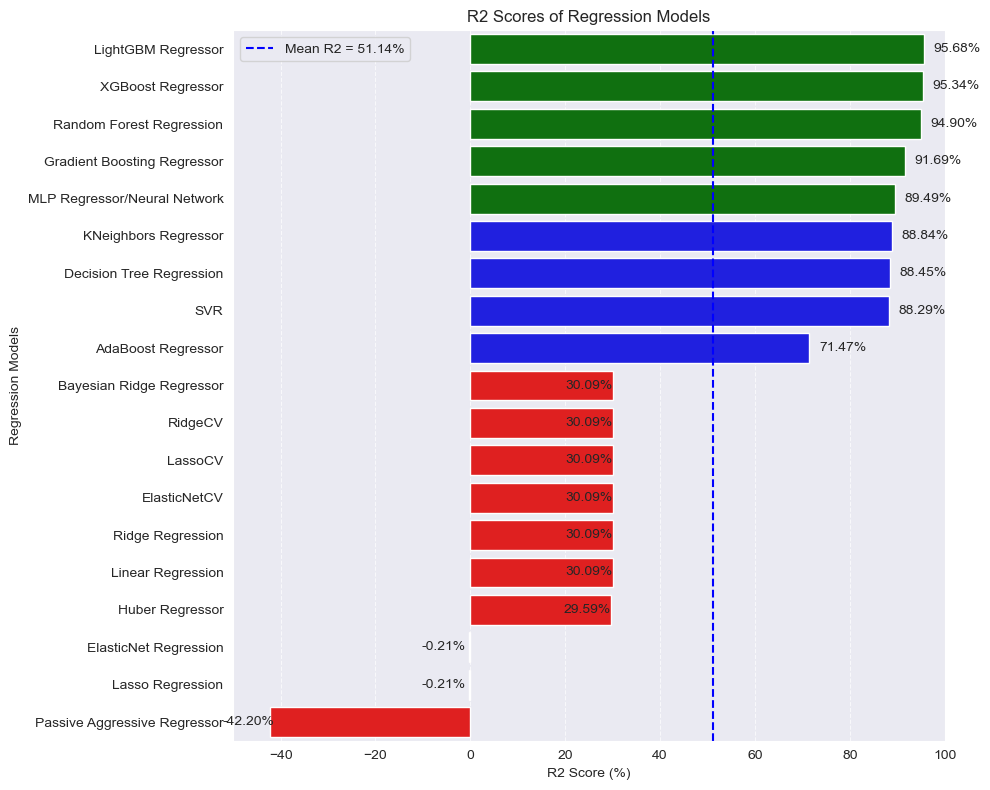

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models and their corresponding R2 scores
models = [
    'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression',
    'SVR', 'Decision Tree Regression', 'Random Forest Regression', 'Gradient Boosting Regressor',
    'AdaBoost Regressor', 'KNeighbors Regressor', 'MLP Regressor/Neural Network', 'Huber Regressor',
    'Passive Aggressive Regressor', 'Bayesian Ridge Regressor', 'RidgeCV', 'LassoCV',
    'ElasticNetCV', 'XGBoost Regressor', 'LightGBM Regressor'
]
r2_scores = [30.09, 30.09, -0.21, -0.21, 88.29, 88.45, 94.90, 91.69, 71.47, 88.84, 89.49, 29.59,
             -42.20, 30.09, 30.09, 30.09, 30.09, 95.34, 95.68]

# Sort the models and R2 scores in descending order
sorted_indices = np.argsort(r2_scores)[::-1]
sorted_models = [models[i] for i in sorted_indices]
sorted_r2_scores = [r2_scores[i] for i in sorted_indices]

# Calculate the mean R2 score
mean_r2 = np.mean(sorted_r2_scores)

# Create a color palette for the bars based on the R2 scores
colors = ['green' if i < 5 else ('red' if score < 70 else 'blue') for i, score in enumerate(sorted_r2_scores)]

# Create the bar plot using Seaborn for better aesthetics
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_r2_scores, y=sorted_models, palette=colors)
plt.axvline(x=mean_r2, color='blue', linestyle='--', label=f'Mean R2 = {mean_r2:.2f}%')
plt.xlabel('R2 Score (%)')
plt.ylabel('Regression Models')
plt.title('R2 Scores of Regression Models')
plt.xlim(-50, 100)  # Set the x-axis limit
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotate the bars with their R2 scores
for i, score in enumerate(sorted_r2_scores):
    plt.text(score + 2 if score >= 70 else score - 10, i, f'{score:.2f}%', va='center')

plt.tight_layout()
plt.show()


# 1.2 Model Tuning

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor


def evaluate_regression_model(model, X, y, cv=5):
    # Calculate R-squared
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=cv)
    r2_mean = np.mean(r2_scores)

    # Calculate MSE and RMSE
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(mse_scores)
    mse_mean = np.mean(mse_scores)
    rmse_mean = np.mean(rmse_scores)

    # Calculate MAE
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv)
    mae_mean = np.mean(mae_scores)

    # Text-based results
    print("R-squared:", r2_mean)
    print("MSE:", mse_mean)
    print("RMSE:", rmse_mean)
    print("MAE:", mae_mean)

    # Plotting results
    metrics = ['R-squared', 'MSE', 'RMSE', 'MAE']
    scores = [r2_mean, mse_mean, rmse_mean, mae_mean]

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Regression Model Evaluation Metrics')
    plt.ylim(min(scores) - 0.1 * max(scores), max(scores) + 0.1 * max(scores))
    plt.grid(axis='y')
    for i in range(len(metrics)):
        plt.text(metrics[i], scores[i] + 0.01 * max(scores), f'{scores[i]:.3f}', ha='center')
    plt.show()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=cv, scoring='r2')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Plotting the learning curve
    plt.figure(figsize=(12, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="blue")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    # Text-based results
    print("Training Sizes:", train_sizes)
    print("Mean Training Scores:", train_scores_mean)
    print("Mean Validation Scores:", val_scores_mean)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, X_train, top_n=10, figsize=(10, 8), title=None):
    # Check if the model has a feature_importances_ attribute
    if not hasattr(model, 'feature_importances_'):
        raise AttributeError(f'{type(model).__name__} does not have feature_importances_ attribute.')

    # Calculate feature importances
    importances = model.feature_importances_

    # Get feature names from the training data
    feature_names = X_train.columns

    # Sort feature importances and feature names
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices][:top_n]
    sorted_feature_names = feature_names[indices][:top_n]

    # Plot feature importances
    plt.figure(figsize=figsize)
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center', color='skyblue')
    plt.yticks(range(len(sorted_importances)), sorted_feature_names)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    if title:
        plt.title(title)
    else:
        plt.title('Top {} Feature Importance'.format(top_n))
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

    # Text-based result
    print("Top {} Feature Importance:".format(top_n))
    for feature, importance in zip(sorted_feature_names, sorted_importances):
        print(f"{feature}: {importance:.4f}")


In [22]:
def plot_actual_vs_predicted_log_scale(true_value, predicted_value):
    plt.figure(figsize=(10, 10))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    # Add a diagonal line representing the ideal prediction
    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-', linewidth=2)

    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.title('Actual vs Predicted Values (Log Scale)', fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 1.2.1. Gradient Boosting Regression:

R-squared: 0.8792461885112008
MSE: 0.008838970968732752
RMSE: 0.09244549309668205
MAE: 0.06112713354274433


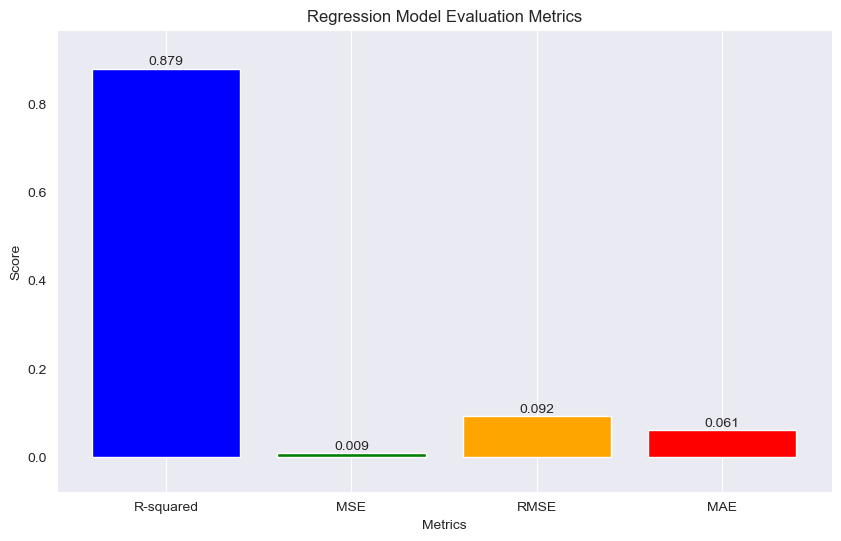

In [117]:
# Create the GradientBoostingRegressor model with best parameters
gb_model = GradientBoostingRegressor()

# Fit the model to the training data
gb_model.fit(X_train_no_split, y_train_no_split)

# Evaluate the model using the evaluate_regression_model function
evaluate_regression_model(gb_model, X_train_no_split, y_train_no_split)

In [103]:
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'loss': ['squared_error', 'huber'],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Create the GradientBoostingRegressor model
gb_model = GradientBoostingRegressor()

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=gb_model, param_grid=parameters, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_1, y_train_1)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}


R-squared: 0.9096416676553385
MSE: 0.006581774733986021
RMSE: 0.07785630123393154
MAE: 0.04451165902404253


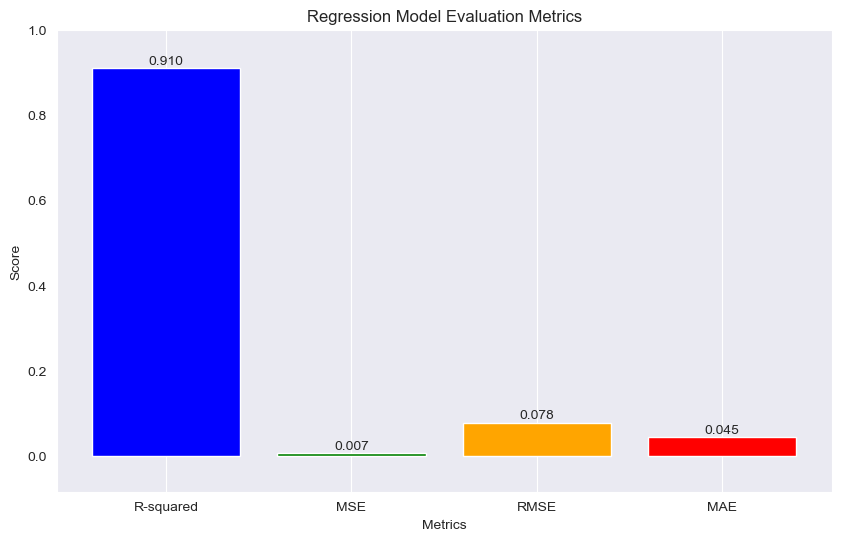

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
best_params = {
    'learning_rate': 0.05,
    'loss': 'huber',
    'max_depth': 7,
    'max_features': 'log2',
    'min_samples_leaf': 2,
    'min_samples_split': 3,
    'n_estimators': 300
}

# Create the GradientBoostingRegressor model with best parameters
best_gb_model = GradientBoostingRegressor(**best_params)

best_gb_model.fit(X_train_no_split, y_train_no_split)

# Evaluate the model using the evaluate_regression_model function
evaluate_regression_model(best_gb_model, X_train_no_split, y_train_no_split)

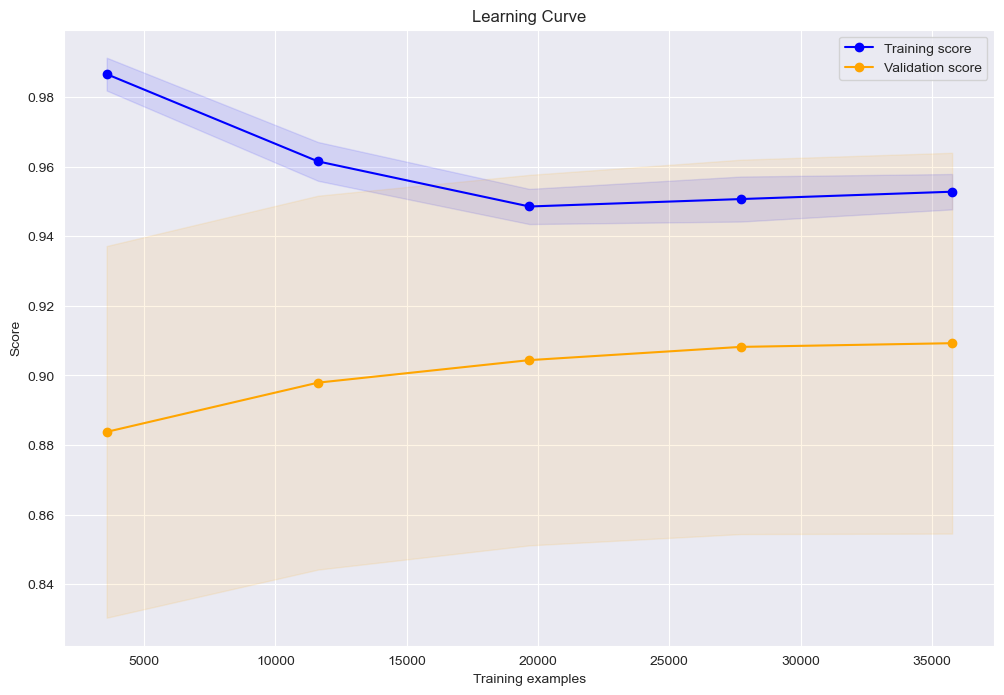

Training Sizes: [ 3576 11622 19669 27716 35763]
Mean Training Scores: [0.98658476 0.96150722 0.94855258 0.95068841 0.95280163]
Mean Validation Scores: [0.88378907 0.89793332 0.90440658 0.90820815 0.9092711 ]


In [111]:
plot_learning_curve(best_gb_model, X_train_no_split, y_train_no_split)

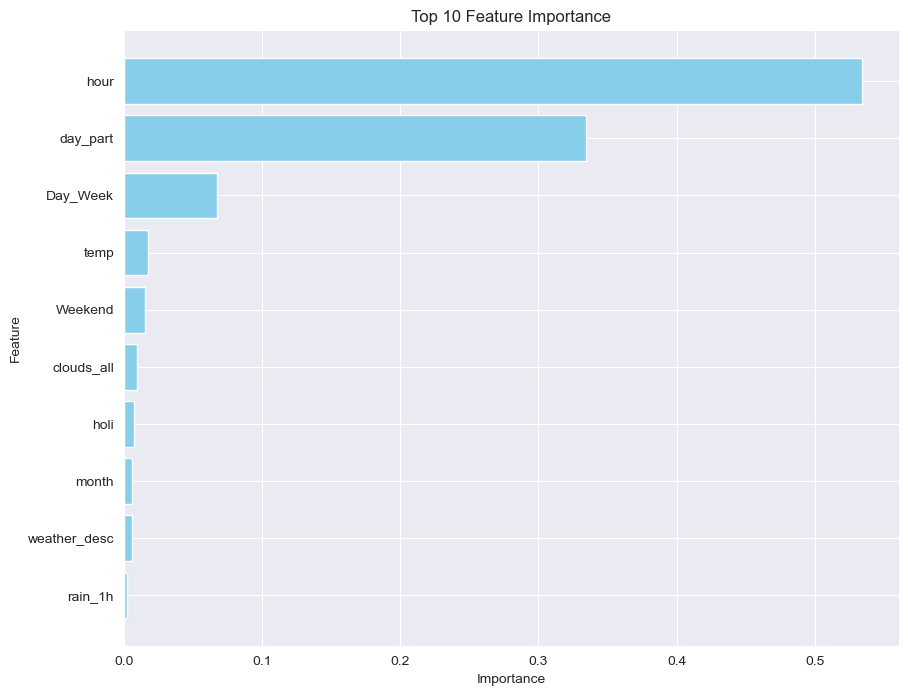

Top 10 Feature Importance:
hour: 0.5340
day_part: 0.3347
Day_Week: 0.0676
temp: 0.0176
Weekend: 0.0151
clouds_all: 0.0096
holi: 0.0071
month: 0.0061
weather_desc: 0.0058
rain_1h: 0.0022


In [137]:
plot_feature_importance(best_gb_model, X_train_no_split, top_n=10, title='Top 10 Feature Importance')

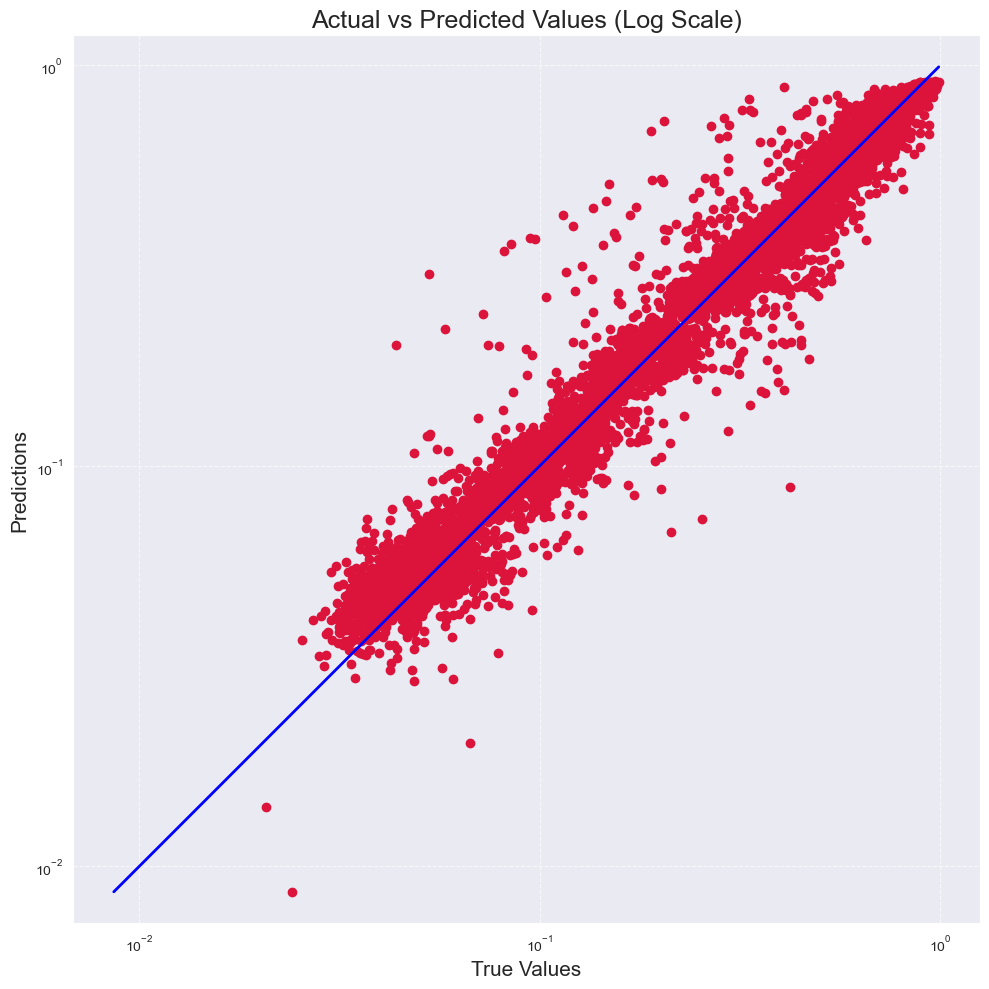

In [127]:
y_pred_test = best_gb_model.predict(X_test_1)

# Now, plot the actual vs predicted values using the plot_actual_vs_predicted function
plot_actual_vs_predicted_log_scale(y_test_1,y_pred_test)

In [24]:
from joblib import dump

# Save the best_gb_model to a file
dump(best_gb_model, 'best_gb_model.joblib')


['best_gb_model.joblib']

# 2. LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 44704, number of used features: 11
[LightGBM] [Info] Start training from score 0.452713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 35763, number of used features: 11
[LightGBM] [Info] Start training from score 0.452613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

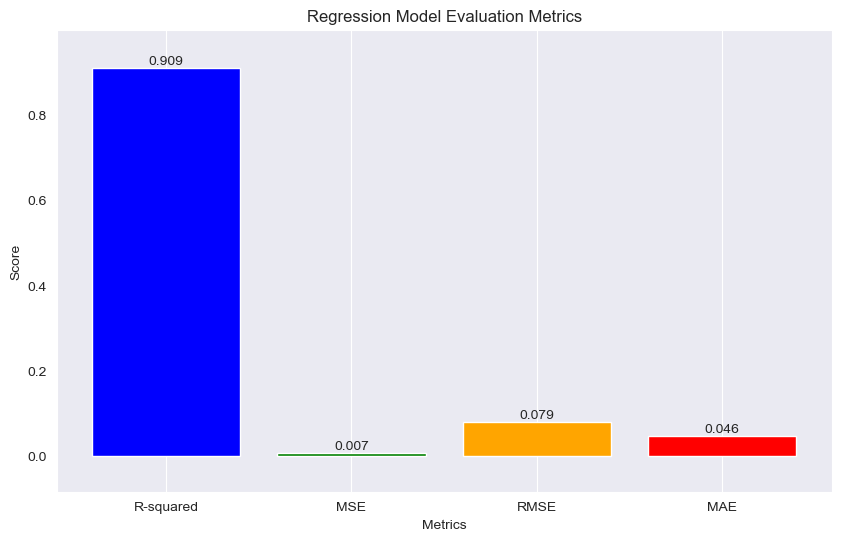

In [128]:
import lightgbm as lgb

# Define the LightGBM regressor model
lgb_model = lgb.LGBMRegressor()

# Fit the model on the training data
lgb_model.fit(X_train_no_split, y_train_no_split)

evaluate_regression_model(lgb_model,X_train_no_split, y_train_no_split)

In [131]:
params = {
    'num_leaves': [20, 30],
    'learning_rate': [0.05, 0.1],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 20],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.1],
    'n_estimators': [100, 200]
}


In [132]:
# Define the LightGBM regressor model
lgb_model = lgb.LGBMRegressor()

# Create Grid Search with cross-validation
grid_search = GridSearchCV(estimator=lgb_model, param_grid=params, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Fit Grid Search on the training data
grid_search.fit(X_train_no_split, y_train_no_split)

# Get the best model and its parameters
best_model2 = grid_search.best_estimator_
best_params2 = grid_search.best_params_

print("Best Parameters:", best_params2)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 44704, number of used features: 11
[LightGBM] [Info] Start training from score 0.452713
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.6}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 44704, number of used features: 11
[LightGBM] [Info] Start training from score 0.452713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 35763, number of used features: 11
[LightGBM] [Info] Start training from score 0.452613
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

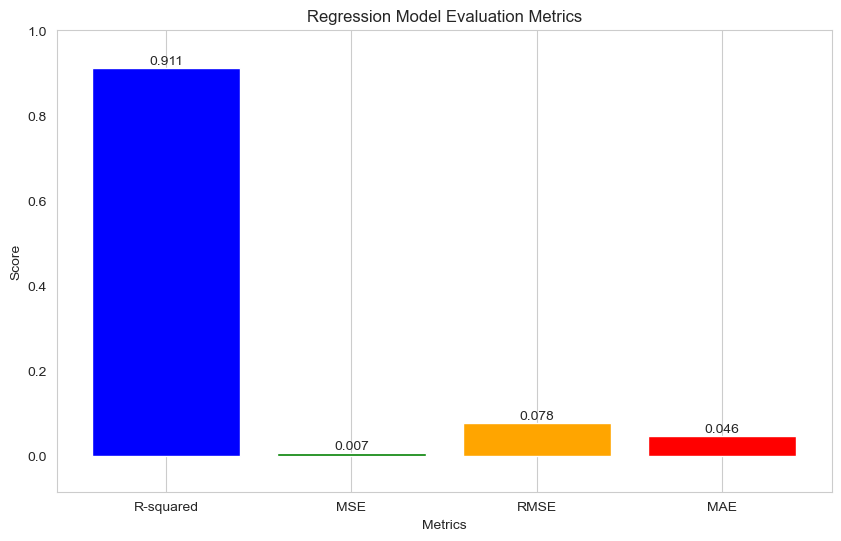

In [56]:
best_params2 = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 100,
    'num_leaves': 30,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample': 0.6
}

# Create the GradientBoostingRegressor model with best parameters
best_lgb_model = lgb.LGBMRegressor(**best_params2)

best_lgb_model.fit(X_train_no_split, y_train_no_split)

# Evaluate the model using the evaluate_regression_model function
evaluate_regression_model(best_lgb_model, X_train_no_split, y_train_no_split)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 3576, number of used features: 10
[LightGBM] [Info] Start training from score 0.411171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 11622, number of used features: 11
[LightGBM] [Info] Start training from score 0.447442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

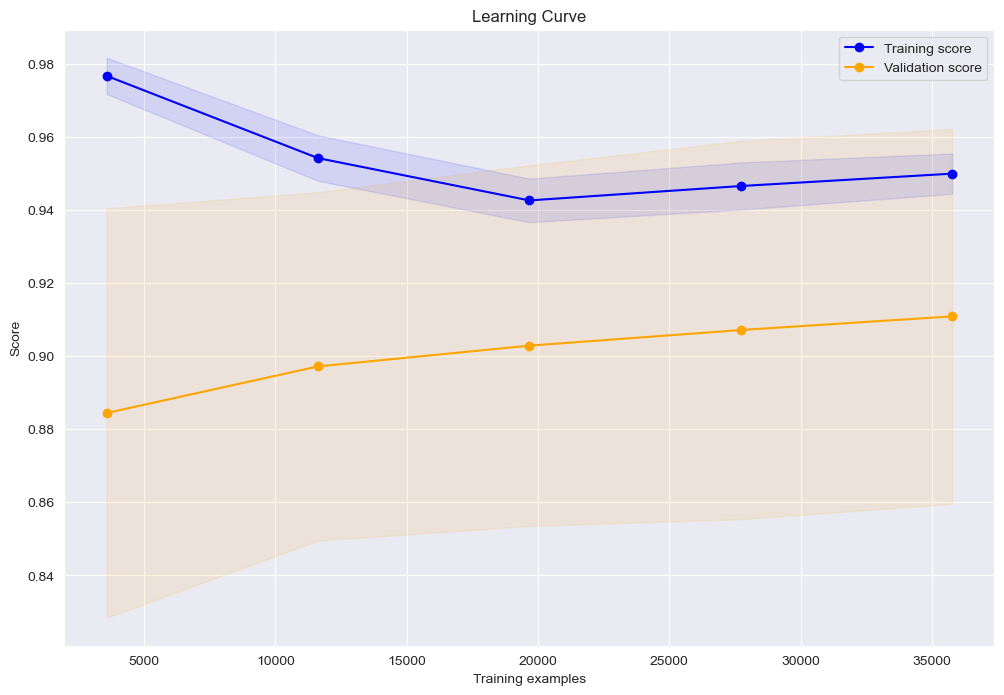

Training Sizes: [ 3576 11622 19669 27716 35763]
Mean Training Scores: [0.97671611 0.95420716 0.94262692 0.94656657 0.94995485]
Mean Validation Scores: [0.88445472 0.89720611 0.90288408 0.90715987 0.91090196]


In [134]:
plot_learning_curve(best_lgb_model, X_train_no_split, y_train_no_split)


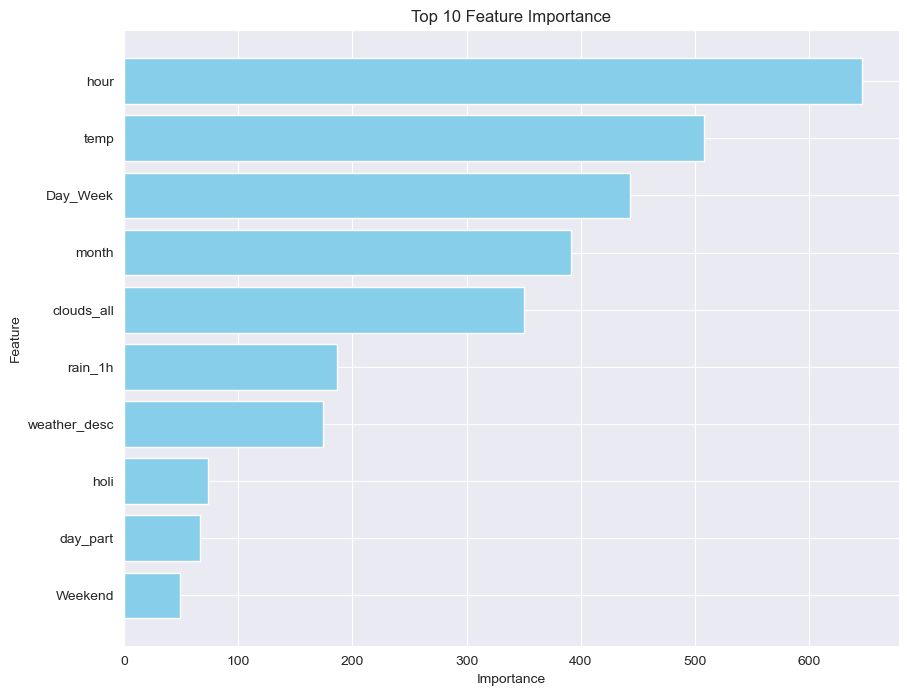

Top 10 Feature Importance:
hour: 646.0000
temp: 508.0000
Day_Week: 443.0000
month: 391.0000
clouds_all: 350.0000
rain_1h: 187.0000
weather_desc: 174.0000
holi: 74.0000
day_part: 67.0000
Weekend: 49.0000


In [138]:
plot_feature_importance(best_lgb_model, X_train_no_split, top_n=10, title='Top 10 Feature Importance')

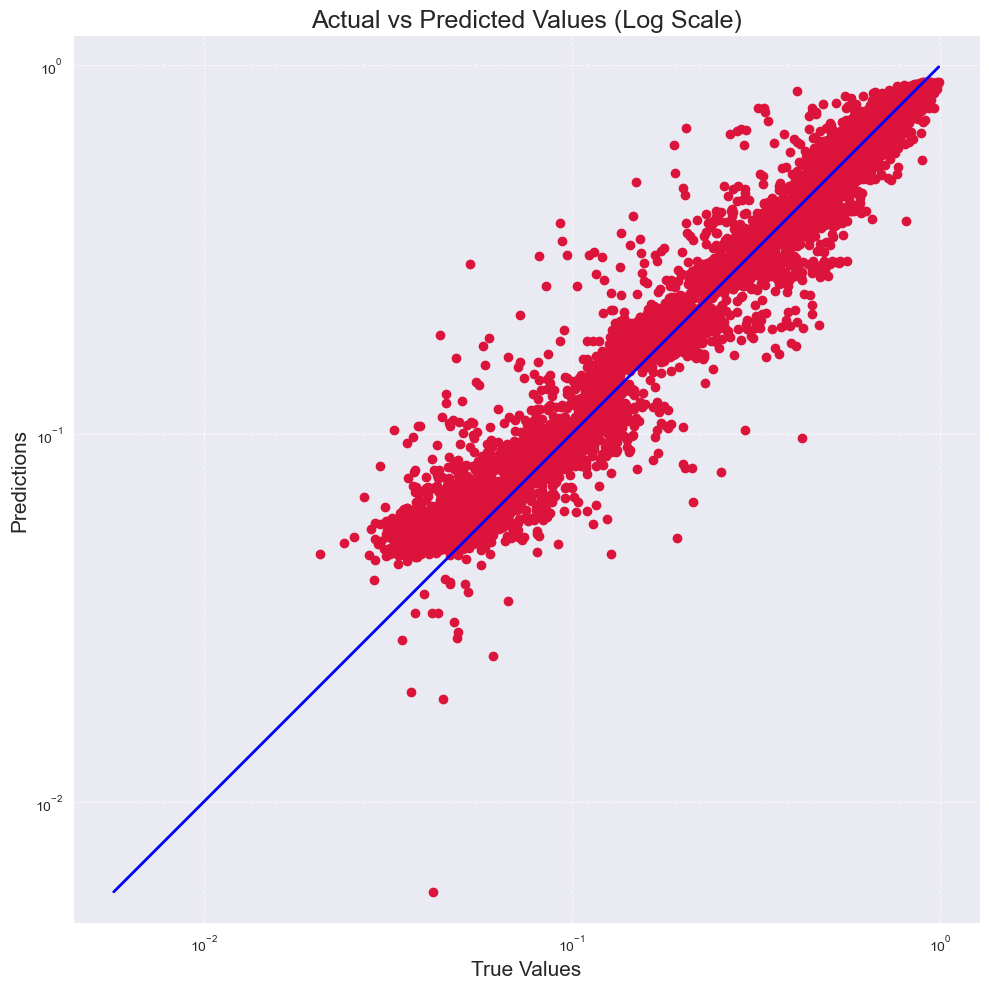

In [139]:
y_pred_test2 = best_lgb_model.predict(X_test_1)

# Now, plot the actual vs predicted values using the plot_actual_vs_predicted function
plot_actual_vs_predicted_log_scale(y_test_1,y_pred_test2)

In [27]:
# Save the best_gb_model to a file
dump(best_lgb_model, 'best_lgb_model.joblib')

['best_lgb_model.joblib']

# 3. Random Forest

R-squared: 0.90154519939411
MSE: 0.0072114544625953335
RMSE: 0.08243855227792657
MAE: 0.04817203989561146


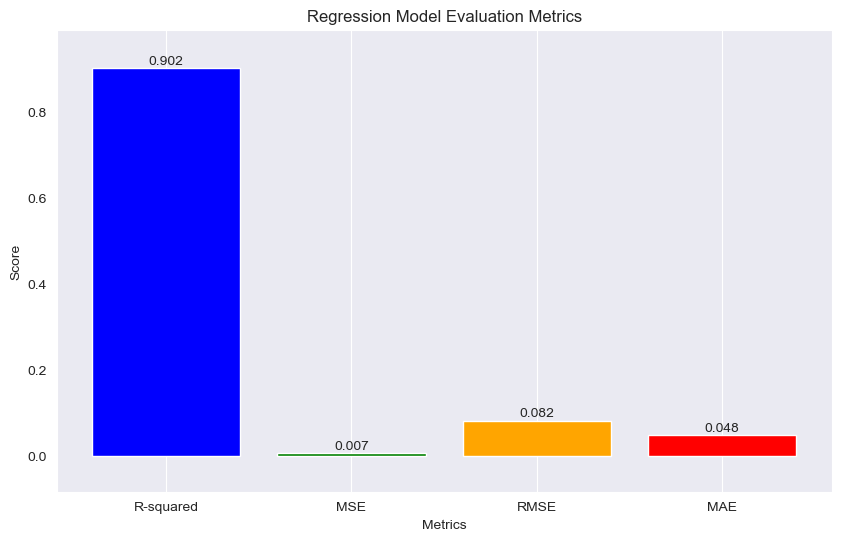

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Create the Random Forest Regressor model
rf_model = RandomForestRegressor()

# Fit the model on the training data
rf_model.fit(X_train_no_split, y_train_no_split)

evaluate_regression_model(rf_model,X_train_no_split, y_train_no_split)

In [33]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the Random Forest Regressor model
rf_model = RandomForestRegressor()

# Create Grid Search with cross-validation for R2 scoring
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Fit Grid Search on the training data
grid_search.fit(X_train_no_split, y_train_no_split)

# Get the best model and its parameters
best_model3 = grid_search.best_estimator_
best_params3 = grid_search.best_params_

print("Best Parameters:", best_params3)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


R-squared: 0.9060315257561184
MSE: 0.006863609684073002
RMSE: 0.07974121093710748
MAE: 0.04631967477261321


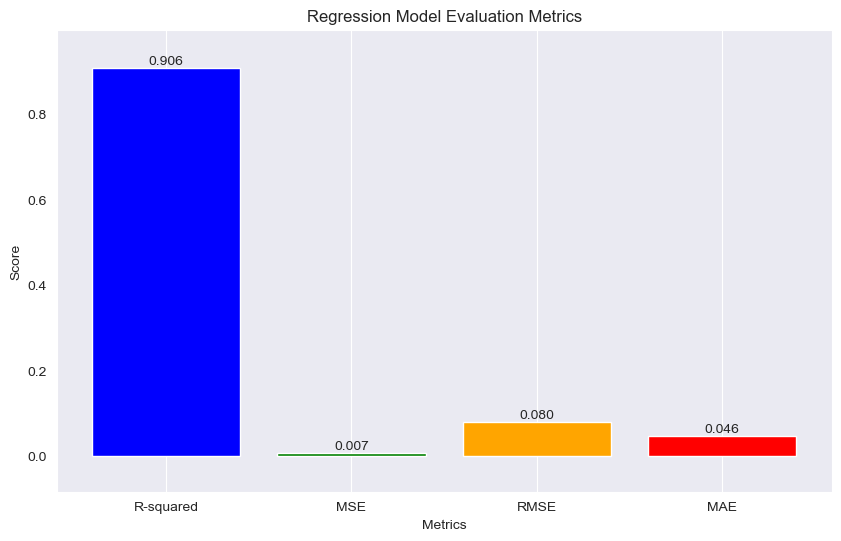

In [35]:
# Create the RandomForestRegressor model with best parameters
best_rf_model = RandomForestRegressor(**best_params3)

best_rf_model.fit(X_train_no_split, y_train_no_split)

# Evaluate the model using the evaluate_regression_model function
evaluate_regression_model(best_rf_model, X_train_no_split, y_train_no_split)

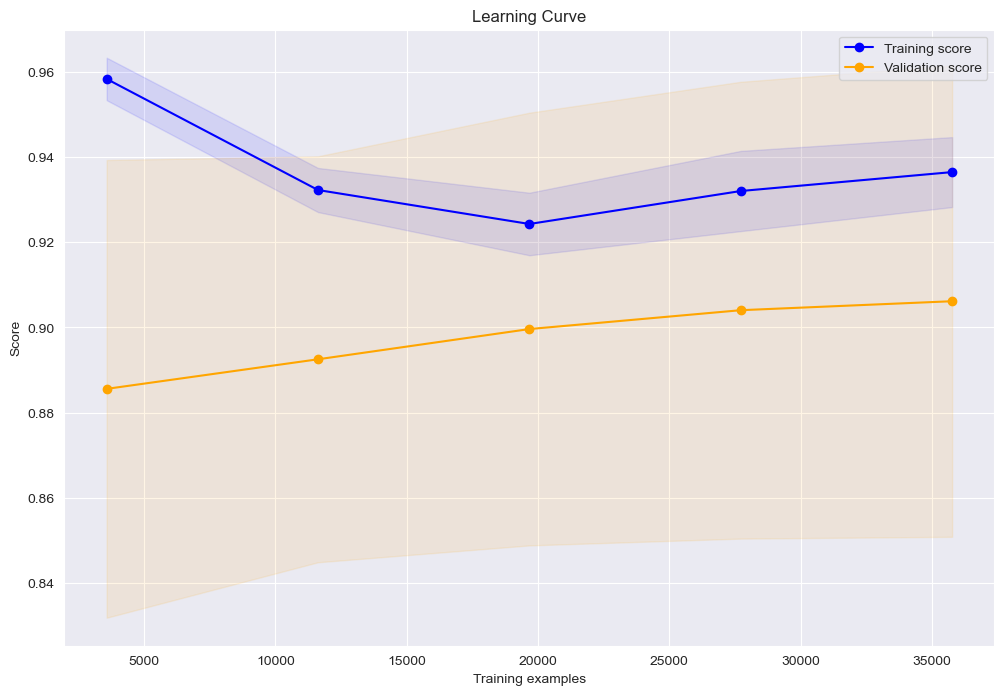

Training Sizes: [ 3576 11622 19669 27716 35763]
Mean Training Scores: [0.95835065 0.93227425 0.92430114 0.9320419  0.936484  ]
Mean Validation Scores: [0.88558935 0.8925355  0.89963291 0.90405915 0.90616683]


In [36]:
plot_learning_curve(best_rf_model, X_train_no_split, y_train_no_split)

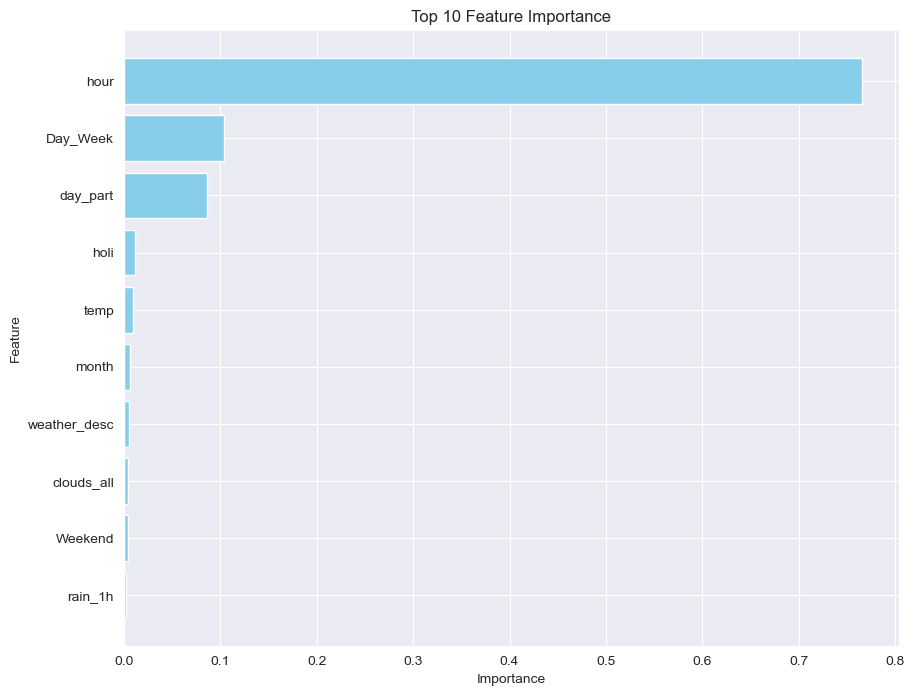

Top 10 Feature Importance:
hour: 0.7653
Day_Week: 0.1039
day_part: 0.0866
holi: 0.0118
temp: 0.0092
month: 0.0070
weather_desc: 0.0054
clouds_all: 0.0048
Weekend: 0.0039
rain_1h: 0.0021


In [49]:
plot_feature_importance(best_rf_model, X_train_no_split, top_n=10, title='Top 10 Feature Importance')

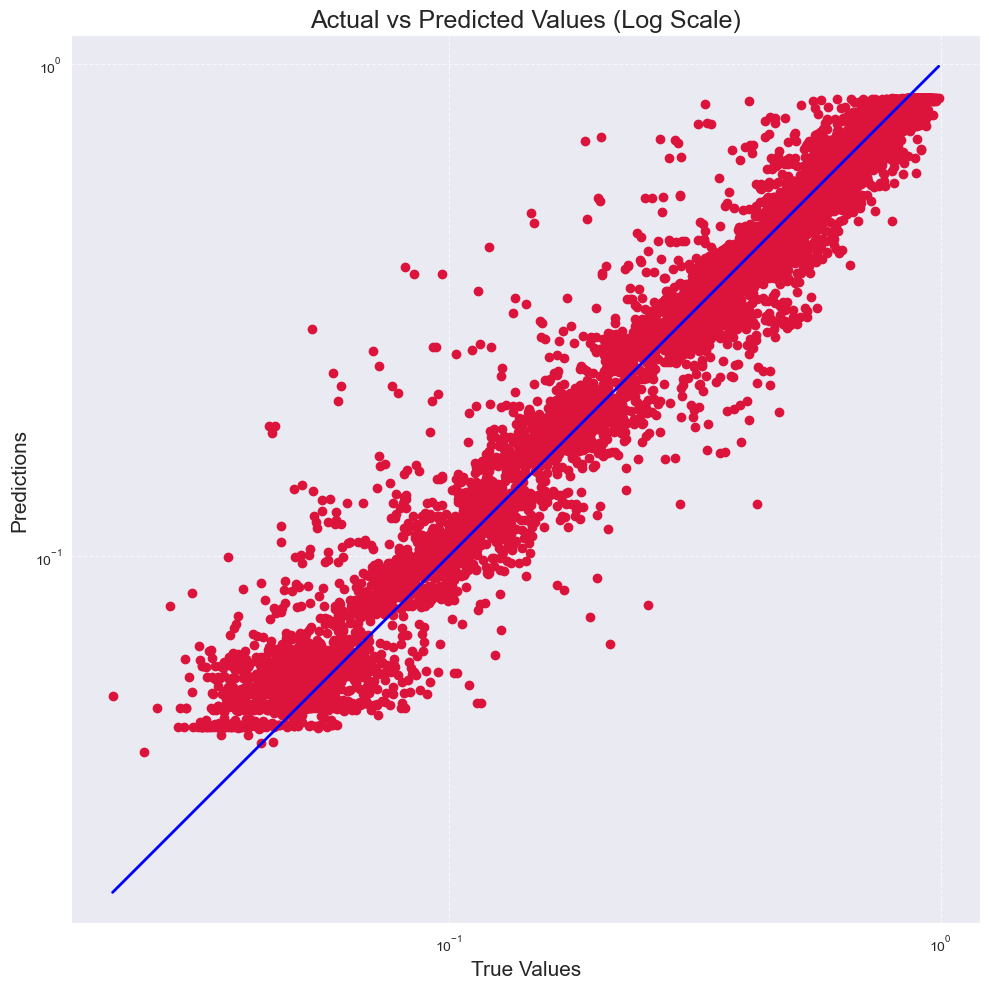

In [37]:
y_pred_test3 = best_rf_model.predict(X_test_1)

# Now, plot the actual vs predicted values using the plot_actual_vs_predicted function
plot_actual_vs_predicted_log_scale(y_test_1,y_pred_test3)

In [38]:
# Save the best_gb_model to a file
dump(best_rf_model, 'best_rf_model.joblib')

['best_rf_model.joblib']

# 4. MLP Regressor/ Neural Network

R-squared: 0.8643035009421652
MSE: 0.009893836557800625
RMSE: 0.09801667412370632
MAE: 0.0685007625680348


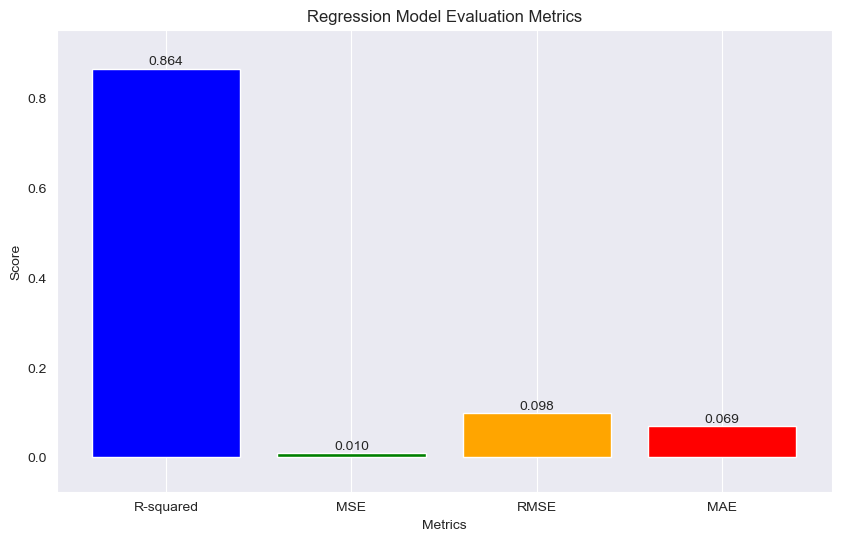

In [39]:
from sklearn.neural_network import MLPRegressor

# Define the MLPRegressor model
mlp_model = MLPRegressor()

# Fit the model on the training data
mlp_model.fit(X_train_no_split, y_train_no_split)

evaluate_regression_model(mlp_model,X_train_no_split, y_train_no_split)

In [42]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'early_stopping': ['true']
}


In [43]:
from sklearn.model_selection import GridSearchCV

# Define the MLPRegressor model
mlp_model = MLPRegressor()

# Create Grid Search with cross-validation for R2 scoring
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)

# Fit Grid Search on the training data
grid_search.fit(X_train_no_split, y_train_no_split)

# Get the best model and its parameters
best_model4 = grid_search.best_estimator_
best_params4 = grid_search.best_params_

print("Best Parameters:", best_params4)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'adam'}


R-squared: 0.8991888449712937
MSE: 0.007286523183216089
RMSE: 0.08284293431138526
MAE: 0.05055683997324861


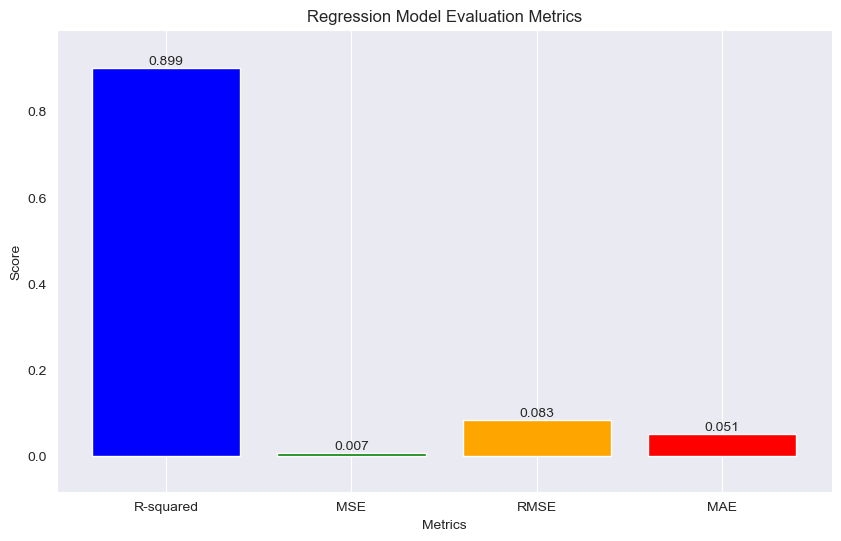

In [45]:
# Create the RandomForestRegressor model with best parameters
best_mlp_model = MLPRegressor(**best_params4, early_stopping=True)

best_mlp_model.fit(X_train_no_split, y_train_no_split)

# Evaluate the model using the evaluate_regression_model function
evaluate_regression_model(best_mlp_model, X_train_no_split, y_train_no_split)

C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


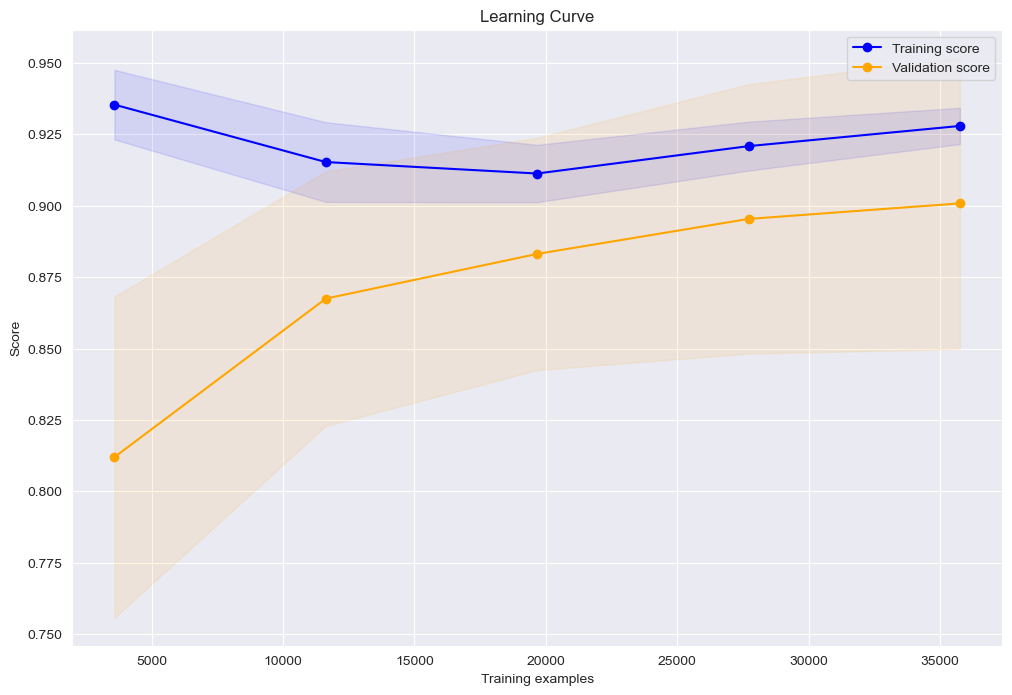

Training Sizes: [ 3576 11622 19669 27716 35763]
Mean Training Scores: [0.93537027 0.91527664 0.91126216 0.92084592 0.92791197]
Mean Validation Scores: [0.81199049 0.86747011 0.88311641 0.89536433 0.90081539]


In [46]:
plot_learning_curve(best_mlp_model, X_train_no_split, y_train_no_split)

In [50]:
plot_feature_importance(best_mlp_model, X_train_no_split, top_n=10, title='Top 10 Feature Importance')

AttributeError: MLPRegressor does not have feature_importances_ attribute.

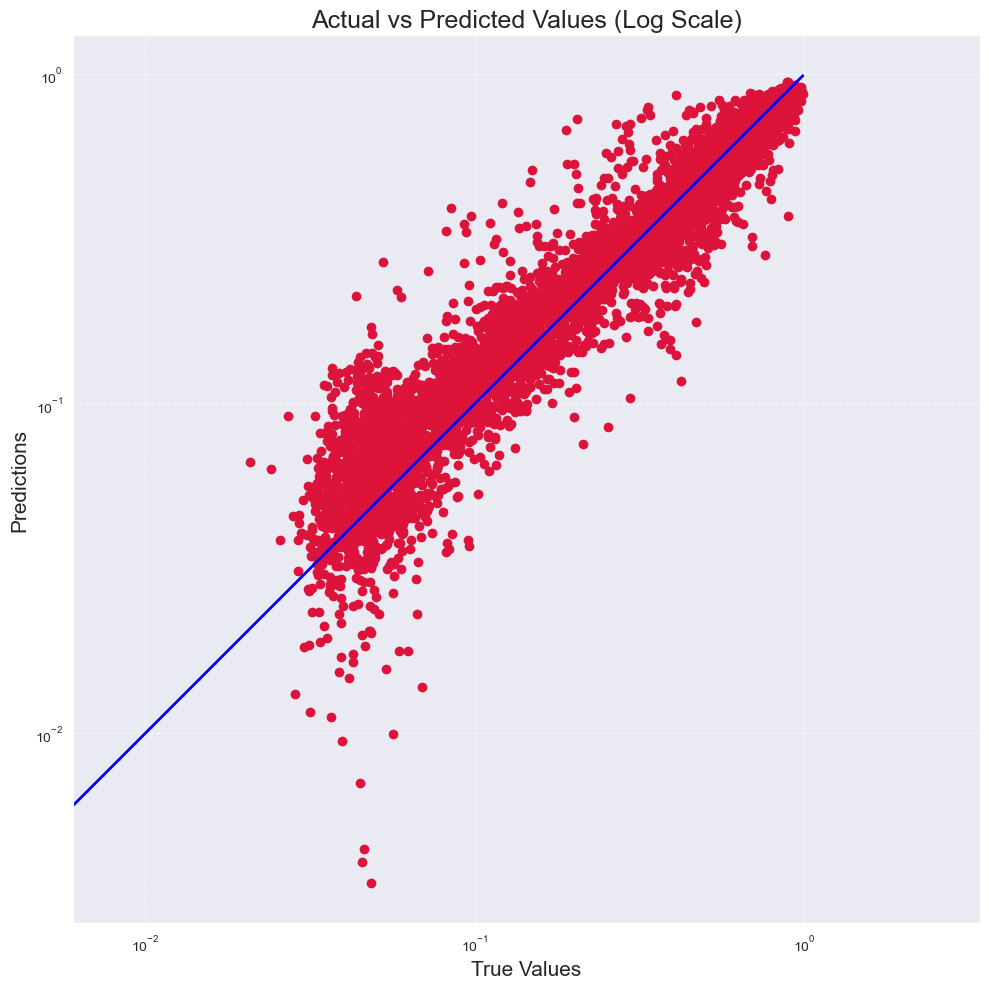

In [47]:
y_pred_test4 = best_mlp_model.predict(X_test_1)

# Now, plot the actual vs predicted values using the plot_actual_vs_predicted function
plot_actual_vs_predicted_log_scale(y_test_1,y_pred_test4)

In [48]:
# Save the best_gb_model to a file
dump(best_mlp_model, 'best_mlp_model.joblib')

['best_mlp_model.joblib']

# Comparison Model 

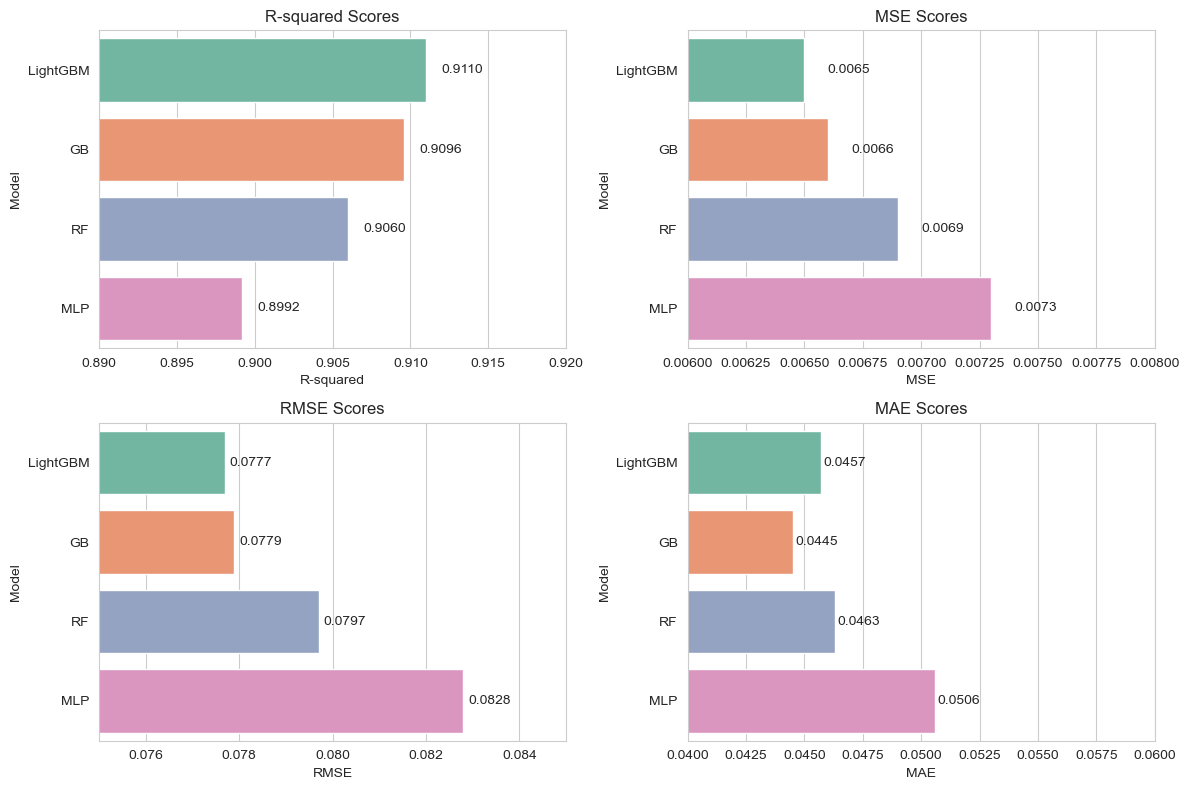

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Model names and corresponding evaluation metrics
models = ['GB', 'LightGBM', 'RF', 'MLP']
r2_scores = [0.9096, 0.9110, 0.9060, 0.8992]
mse_scores = [0.0066, 0.0065, 0.0069, 0.0073]
rmse_scores = [0.0779, 0.0777, 0.0797, 0.0828]
mae_scores = [0.0445, 0.0457, 0.0463, 0.0506]

# Create a DataFrame for easier plotting
import pandas as pd
data = pd.DataFrame({
    'Model': models,
    'R-squared': r2_scores,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'MAE': mae_scores
})

# Sort the DataFrame by each metric for better visualization
data.sort_values(by='R-squared', ascending=False, inplace=True)
data.reset_index(drop=True, inplace=True)

# Set the style and color palette
sns.set_style("whitegrid")
colors = sns.color_palette("Set2")

# Plotting
plt.figure(figsize=(12, 8))

# Plot R-squared scores
plt.subplot(221)
ax1 = sns.barplot(x='R-squared', y='Model', data=data, palette=colors)
plt.title('R-squared Scores')
plt.xlabel('R-squared')
plt.xlim(0.89, 0.92)

# Add labels to R-squared bars
for i, (model, score) in enumerate(zip(data['Model'], data['R-squared'])):
    ax1.text(score + 0.001, i, f'{score:.4f}', va='center')

# Plot MSE scores
plt.subplot(222)
ax2 = sns.barplot(x='MSE', y='Model', data=data, palette=colors)
plt.title('MSE Scores')
plt.xlabel('MSE')
plt.xlim(0.006, 0.008)

# Add labels to MSE bars
for i, (model, score) in enumerate(zip(data['Model'], data['MSE'])):
    ax2.text(score + 0.0001, i, f'{score:.4f}', va='center')

# Plot RMSE scores
plt.subplot(223)
ax3 = sns.barplot(x='RMSE', y='Model', data=data, palette=colors)
plt.title('RMSE Scores')
plt.xlabel('RMSE')
plt.xlim(0.075, 0.085)

# Add labels to RMSE bars
for i, (model, score) in enumerate(zip(data['Model'], data['RMSE'])):
    ax3.text(score + 0.0001, i, f'{score:.4f}', va='center')

# Plot MAE scores
plt.subplot(224)
ax4 = sns.barplot(x='MAE', y='Model', data=data, palette=colors)
plt.title('MAE Scores')
plt.xlabel('MAE')
plt.xlim(0.04, 0.06)

# Add labels to MAE bars
for i, (model, score) in enumerate(zip(data['Model'], data['MAE'])):
    ax4.text(score + 0.0001, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()


In [ ]:
best_gb_model
best_lgb_model
best_mlp_model
best_rf_model